<a href="https://colab.research.google.com/github/Vortex-002/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hi! Welcome to my project.
> Here you will get to see that how write simple code in colab can make it possible to rule out skin diseases efficiently though this project is purely for educational purposes and should not be used to actually diagnose any disease.

>Every code block will have a text block preceding it to explain what happens in it.
> Link to the Dataset: https://www.kaggle.com/datasets/adityush/eczema2

# Calculating Mean and Standard Deviation

Here I am calculating the mean and standard deviation to rule out the normalizing facotrs which are mean and standard deviation for the normalising transform applied on the dataset.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data', transform=transform)


loader = DataLoader(dataset, batch_size=32, shuffle=False)


mean = 0.0
std = 0.0
total_images = 0


for images, _ in tqdm(loader, desc="Calculating mean and std", unit="batch"):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples


mean /= total_images
std /= total_images

print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')


# Dataloader Block
- I applied transforms to the images as in data augmentation to alter the image so that the model learns better
- I load the dataset
- I split the dataset with `random_spilt` in 80 10 10 format
- Then separated them into batches

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.6314, 0.5293, 0.4935], [0.1907, 0.1813, 0.1858])
])


dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data', transform=transform)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2956
Validation dataset size: 369
Test dataset size: 371


# THE MODEL

> This is the model architecture a detailed explanation of how it works is in: https://docs.google.com/document/d/1hQK2o809k89_jgKlYjPn3Y3VJqX87nfTIfLZN6BNaLo/edit?tab=t.0

> To sum it up briefly
-  3 convolutional layers (9-17)
-  LSTM (22)
-  Fully connected layers (25 - 27)
-  Forward function with: (29-46)
      - Feature extraction (31-33)
      - RNN reshaping
      - The actual RNN
      - FC + Dropout + Output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()


        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)


        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)


        self.fc1 = nn.Linear(64 * 2, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))


        b, c, h, w = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(b, -1, c)


        x, _ = self.lstm(x)
        x = x[:, -1, :]


        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))

        return x


# The Train Block
> Here I declare the optimizer as SGD with momentum and also we take Binary Cross Entropy Loss for our loss function. I have kept number of epochs as 10.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 50
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.01
early_stop_patience = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

criterion = nn.BCELoss()

best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", ncols=100)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = train_loss / len(train_loader)
    acc = 100 * correct / total
    print(f"\nEpoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    # === Validation ===
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # === Scheduler Step ===
    scheduler.step(avg_val_loss)
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # === Early Stopping Logic ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model, "SGD.pt")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stop counter: {early_stop_counter}/{early_stop_patience}")

    if early_stop_counter >= early_stop_patience:
        print("Stopped")
        break


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch [1/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=62.2, loss=0.654]



✅ Epoch 1: Avg Loss = 0.6443, Accuracy = 62.18%
🧪 Validation Loss: 0.5639, Accuracy: 77.51%
📉 Current Learning Rate: 0.001000


Epoch [2/50]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=79.2, loss=0.427]



✅ Epoch 2: Avg Loss = 0.5203, Accuracy = 79.19%
🧪 Validation Loss: 0.4018, Accuracy: 89.70%
📉 Current Learning Rate: 0.001000


Epoch [3/50]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.72it/s, acc=85.1, loss=0.331]



✅ Epoch 3: Avg Loss = 0.4232, Accuracy = 85.15%
🧪 Validation Loss: 0.3183, Accuracy: 90.24%
📉 Current Learning Rate: 0.001000


Epoch [4/50]: 100%|█████████████████████████████| 93/93 [00:54<00:00,  1.72it/s, acc=87, loss=0.736]



✅ Epoch 4: Avg Loss = 0.3670, Accuracy = 87.01%
🧪 Validation Loss: 0.2588, Accuracy: 91.60%
📉 Current Learning Rate: 0.001000


Epoch [5/50]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.72it/s, acc=87.8, loss=0.118]



✅ Epoch 5: Avg Loss = 0.3367, Accuracy = 87.82%
🧪 Validation Loss: 0.2380, Accuracy: 92.14%
📉 Current Learning Rate: 0.001000


Epoch [6/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=88.3, loss=0.524]



✅ Epoch 6: Avg Loss = 0.3287, Accuracy = 88.29%
🧪 Validation Loss: 0.2107, Accuracy: 93.50%
📉 Current Learning Rate: 0.001000


Epoch [7/50]: 100%|██████████████████████████████| 93/93 [00:54<00:00,  1.72it/s, acc=88, loss=0.42]



✅ Epoch 7: Avg Loss = 0.3275, Accuracy = 87.96%
🧪 Validation Loss: 0.2371, Accuracy: 91.87%
📉 Current Learning Rate: 0.001000
No improvement. Early stop counter: 1/5


Epoch [8/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=88.2, loss=0.347]



✅ Epoch 8: Avg Loss = 0.3199, Accuracy = 88.16%
🧪 Validation Loss: 0.2211, Accuracy: 93.22%
📉 Current Learning Rate: 0.001000
No improvement. Early stop counter: 2/5


Epoch [9/50]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.71it/s, acc=88.6, loss=0.249]



✅ Epoch 9: Avg Loss = 0.3067, Accuracy = 88.63%
🧪 Validation Loss: 0.1929, Accuracy: 94.04%
📉 Current Learning Rate: 0.001000


Epoch [10/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=88.7, loss=0.575]



✅ Epoch 10: Avg Loss = 0.3041, Accuracy = 88.73%
🧪 Validation Loss: 0.2196, Accuracy: 92.14%
📉 Current Learning Rate: 0.001000
No improvement. Early stop counter: 1/5


Epoch [11/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=88.3, loss=0.241]



✅ Epoch 11: Avg Loss = 0.3139, Accuracy = 88.29%
🧪 Validation Loss: 0.2182, Accuracy: 94.04%
📉 Current Learning Rate: 0.001000
No improvement. Early stop counter: 2/5


Epoch [12/50]: 100%|█████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=89.6, loss=0.0969]



✅ Epoch 12: Avg Loss = 0.2803, Accuracy = 89.61%
🧪 Validation Loss: 0.1806, Accuracy: 94.58%
📉 Current Learning Rate: 0.001000


Epoch [13/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=90.3, loss=0.406]



✅ Epoch 13: Avg Loss = 0.2733, Accuracy = 90.29%
🧪 Validation Loss: 0.1941, Accuracy: 92.95%
📉 Current Learning Rate: 0.001000
No improvement. Early stop counter: 1/5


Epoch [14/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=89.9, loss=0.231]



✅ Epoch 14: Avg Loss = 0.2816, Accuracy = 89.92%
🧪 Validation Loss: 0.2440, Accuracy: 93.50%
📉 Current Learning Rate: 0.001000
No improvement. Early stop counter: 2/5


Epoch [15/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=89.2, loss=0.136]



✅ Epoch 15: Avg Loss = 0.2949, Accuracy = 89.21%
🧪 Validation Loss: 0.1925, Accuracy: 94.85%
📉 Current Learning Rate: 0.000500
No improvement. Early stop counter: 3/5


Epoch [16/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=90.4, loss=0.263]



✅ Epoch 16: Avg Loss = 0.2635, Accuracy = 90.36%
🧪 Validation Loss: 0.1732, Accuracy: 95.93%
📉 Current Learning Rate: 0.000500


Epoch [17/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=91.7, loss=0.114]



✅ Epoch 17: Avg Loss = 0.2423, Accuracy = 91.75%
🧪 Validation Loss: 0.1460, Accuracy: 96.21%
📉 Current Learning Rate: 0.000500


Epoch [18/50]: 100%|████████████████████████████| 93/93 [00:54<00:00,  1.72it/s, acc=91, loss=0.118]



✅ Epoch 18: Avg Loss = 0.2471, Accuracy = 91.04%
🧪 Validation Loss: 0.1163, Accuracy: 97.56%
📉 Current Learning Rate: 0.000500


Epoch [19/50]: 100%|██████████████████████████| 93/93 [00:54<00:00,  1.72it/s, acc=93.1, loss=0.513]



✅ Epoch 19: Avg Loss = 0.2135, Accuracy = 93.13%
🧪 Validation Loss: 0.1723, Accuracy: 94.85%
📉 Current Learning Rate: 0.000500
No improvement. Early stop counter: 1/5


Epoch [20/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=91.5, loss=1.03]



✅ Epoch 20: Avg Loss = 0.2408, Accuracy = 91.54%
🧪 Validation Loss: 0.1382, Accuracy: 95.66%
📉 Current Learning Rate: 0.000500
No improvement. Early stop counter: 2/5


Epoch [21/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=92.1, loss=0.369]



✅ Epoch 21: Avg Loss = 0.2290, Accuracy = 92.08%
🧪 Validation Loss: 0.1457, Accuracy: 94.85%
📉 Current Learning Rate: 0.000250
No improvement. Early stop counter: 3/5


Epoch [22/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=92.1, loss=0.235]



✅ Epoch 22: Avg Loss = 0.2295, Accuracy = 92.08%
🧪 Validation Loss: 0.1400, Accuracy: 96.21%
📉 Current Learning Rate: 0.000250
No improvement. Early stop counter: 4/5


Epoch [23/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=93, loss=0.0746]



✅ Epoch 23: Avg Loss = 0.2150, Accuracy = 92.96%
🧪 Validation Loss: 0.1792, Accuracy: 95.12%
📉 Current Learning Rate: 0.000250
No improvement. Early stop counter: 5/5
Stopped


#Comparison code
This section is purely for comparison with an optimiser as Adam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 50
learning_rate = 0.001
weight_decay = 0.01
early_stop_patience = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

criterion = nn.BCELoss()

best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", ncols=100)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total
    print(f"\nEpoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    # === Validation ===
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # === Scheduler Step ===
    scheduler.step(avg_val_loss)
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # === Early Stopping ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model, "Adam.pt")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stop counter: {early_stop_counter}/{early_stop_patience}")

    if early_stop_counter >= early_stop_patience:
        print("Stopped.")
        break


Epoch [1/50]: 100%|████████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=85.2, loss=0.46]



Epoch 1: Avg Loss = 0.3870, Accuracy = 85.22%
Validation Loss: 0.2662, Accuracy: 92.14%
Current Learning Rate: 0.001000


Epoch [2/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=87.5, loss=0.066]



Epoch 2: Avg Loss = 0.3278, Accuracy = 87.52%
Validation Loss: 0.2151, Accuracy: 93.22%
Current Learning Rate: 0.001000


Epoch [3/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=88.8, loss=0.0954]



Epoch 3: Avg Loss = 0.3039, Accuracy = 88.77%
Validation Loss: 0.1885, Accuracy: 94.31%
Current Learning Rate: 0.001000


Epoch [4/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=89.1, loss=0.434]



Epoch 4: Avg Loss = 0.2960, Accuracy = 89.07%
Validation Loss: 0.2530, Accuracy: 91.60%
Current Learning Rate: 0.001000
No improvement. Early stop counter: 1/5


Epoch [5/50]: 100%|█████████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=90, loss=0.372]



Epoch 5: Avg Loss = 0.2754, Accuracy = 89.99%
Validation Loss: 0.1976, Accuracy: 94.85%
Current Learning Rate: 0.001000
No improvement. Early stop counter: 2/5


Epoch [6/50]: 100%|████████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=90.5, loss=0.46]



Epoch 6: Avg Loss = 0.2596, Accuracy = 90.53%
Validation Loss: 0.2341, Accuracy: 93.22%
Current Learning Rate: 0.000500
No improvement. Early stop counter: 3/5


Epoch [7/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=91.6, loss=0.861]



Epoch 7: Avg Loss = 0.2418, Accuracy = 91.61%
Validation Loss: 0.1283, Accuracy: 96.75%
Current Learning Rate: 0.000500


Epoch [8/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=91.6, loss=0.312]



Epoch 8: Avg Loss = 0.2367, Accuracy = 91.61%
Validation Loss: 0.1708, Accuracy: 94.85%
Current Learning Rate: 0.000500
No improvement. Early stop counter: 1/5


Epoch [9/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=92.5, loss=0.0989]



Epoch 9: Avg Loss = 0.2154, Accuracy = 92.52%
Validation Loss: 0.1617, Accuracy: 94.58%
Current Learning Rate: 0.000500
No improvement. Early stop counter: 2/5


Epoch [10/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.73it/s, acc=92.2, loss=0.333]



Epoch 10: Avg Loss = 0.2167, Accuracy = 92.19%
Validation Loss: 0.1627, Accuracy: 94.58%
Current Learning Rate: 0.000250
No improvement. Early stop counter: 3/5


Epoch [11/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=92.6, loss=0.132]



Epoch 11: Avg Loss = 0.2132, Accuracy = 92.59%
Validation Loss: 0.1764, Accuracy: 94.85%
Current Learning Rate: 0.000250
No improvement. Early stop counter: 4/5


Epoch [12/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=92.9, loss=0.327]



Epoch 12: Avg Loss = 0.2070, Accuracy = 92.86%
Validation Loss: 0.1088, Accuracy: 97.56%
Current Learning Rate: 0.000250


Epoch [13/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=93.4, loss=0.245]



Epoch 13: Avg Loss = 0.1983, Accuracy = 93.44%
Validation Loss: 0.1286, Accuracy: 97.02%
Current Learning Rate: 0.000250
No improvement. Early stop counter: 1/5


Epoch [14/50]: 100%|██████████████████████████| 93/93 [00:52<00:00,  1.76it/s, acc=94.2, loss=0.326]



Epoch 14: Avg Loss = 0.1828, Accuracy = 94.18%
Validation Loss: 0.1366, Accuracy: 96.48%
Current Learning Rate: 0.000250
No improvement. Early stop counter: 2/5


Epoch [15/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=93.7, loss=0.121]



Epoch 15: Avg Loss = 0.1881, Accuracy = 93.71%
Validation Loss: 0.1729, Accuracy: 94.85%
Current Learning Rate: 0.000125
No improvement. Early stop counter: 3/5


Epoch [16/50]: 100%|███████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=94, loss=0.0483]



Epoch 16: Avg Loss = 0.1796, Accuracy = 94.05%
Validation Loss: 0.1133, Accuracy: 96.48%
Current Learning Rate: 0.000125
No improvement. Early stop counter: 4/5


Epoch [17/50]: 100%|█████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=94.6, loss=0.0718]



Epoch 17: Avg Loss = 0.1607, Accuracy = 94.59%
Validation Loss: 0.0812, Accuracy: 97.83%
Current Learning Rate: 0.000125


Epoch [18/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.75it/s, acc=94.3, loss=0.227]



Epoch 18: Avg Loss = 0.1708, Accuracy = 94.28%
Validation Loss: 0.1249, Accuracy: 96.75%
Current Learning Rate: 0.000125
No improvement. Early stop counter: 1/5


Epoch [19/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=94.8, loss=0.136]



Epoch 19: Avg Loss = 0.1615, Accuracy = 94.79%
Validation Loss: 0.0996, Accuracy: 96.75%
Current Learning Rate: 0.000125
No improvement. Early stop counter: 2/5


Epoch [20/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=94.5, loss=0.044]



Epoch 20: Avg Loss = 0.1656, Accuracy = 94.45%
Validation Loss: 0.1184, Accuracy: 96.48%
Current Learning Rate: 0.000063
No improvement. Early stop counter: 3/5


Epoch [21/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=94.7, loss=0.278]



Epoch 21: Avg Loss = 0.1577, Accuracy = 94.69%
Validation Loss: 0.1053, Accuracy: 96.75%
Current Learning Rate: 0.000063
No improvement. Early stop counter: 4/5


Epoch [22/50]: 100%|██████████████████████████| 93/93 [00:53<00:00,  1.74it/s, acc=95.4, loss=0.251]



Epoch 22: Avg Loss = 0.1444, Accuracy = 95.40%
Validation Loss: 0.1116, Accuracy: 96.75%
Current Learning Rate: 0.000063
No improvement. Early stop counter: 5/5
Stopped.


# The Metrics Block
> Here we find out the:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - Specificity
  - ROC AUC
  - ROC Plot
  - Confusion Matrix

Accuracy    : 0.9702
Precision   : 0.9514
Recall      : 0.9716
F1 Score    : 0.9614
Specificity : 0.9693
ROC AUC     : 0.9922


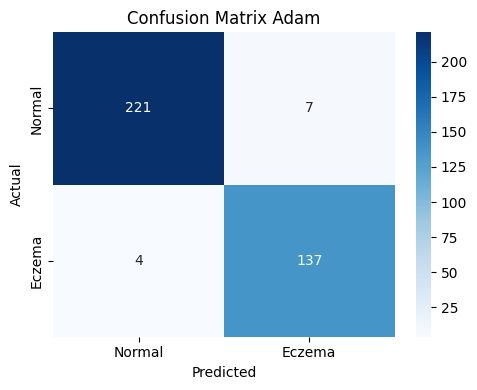

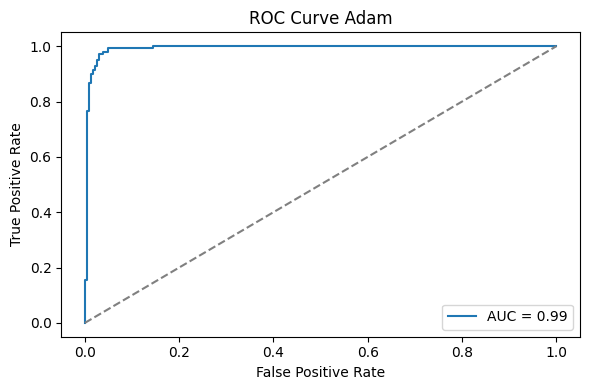

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/Adam.pt"
model = torch.load(model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval()


def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > threshold).float().cpu().numpy()
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-6)

    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"ROC AUC     : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Eczema'], yticklabels=['Normal', 'Eczema'])
    plt.title("Confusion Matrix Adam")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Adam")
    plt.legend()
    plt.tight_layout()
    plt.show()


evaluate_model(model, val_loader)


# This is the test metrics code block
 - All I have done here is that I have evaluated the model based on the evaluation metrics used above but only for the test set.

Accuracy    : 0.9488
Precision   : 0.9787
Recall      : 0.8961
F1 Score    : 0.9356
Specificity : 0.9862
ROC AUC     : 0.9783


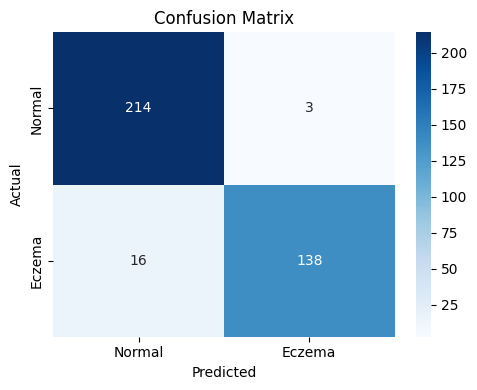

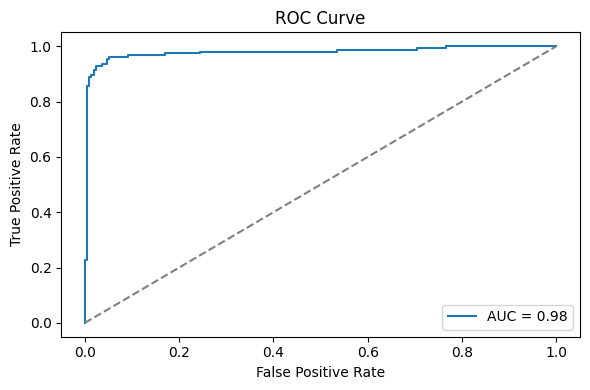

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/Adam.pt"
model = torch.load(model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval()


def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > threshold).float().cpu().numpy()
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-6)

    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"ROC AUC     : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Eczema'], yticklabels=['Normal', 'Eczema'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


evaluate_model(model, test_loader)


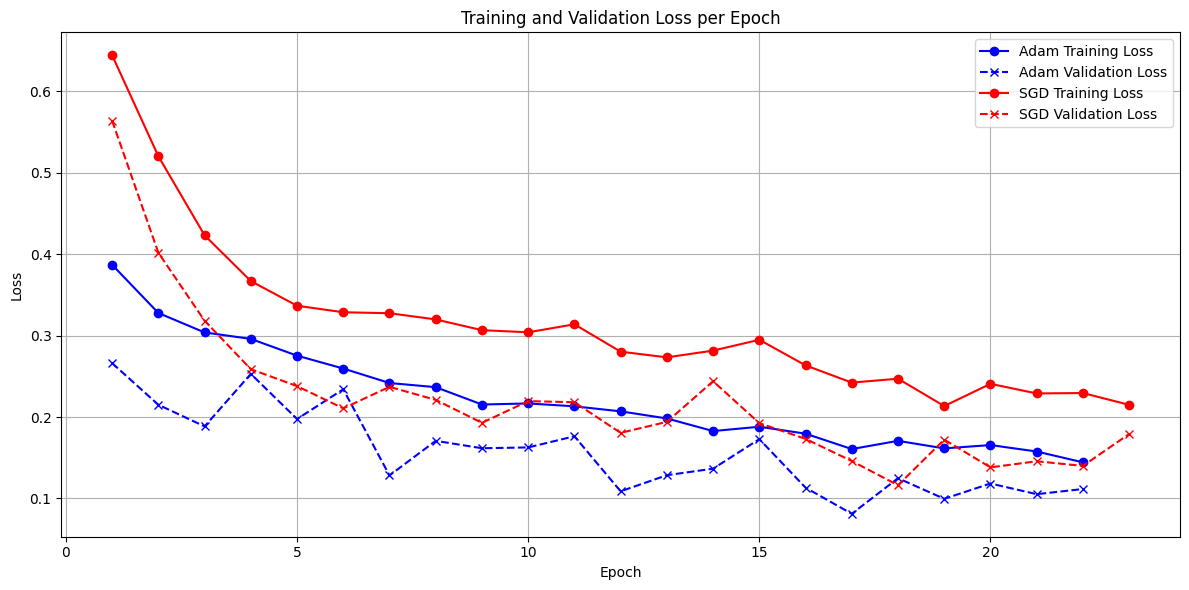

In [ ]:
import matplotlib.pyplot as plt

# Epoch numbers
epochs_adam = list(range(1, 23))
epochs_sgd = list(range(1, 24))

# Adam optimizer data
adam_avg_loss = [
    0.3870, 0.3278, 0.3039, 0.2960, 0.2754, 0.2596, 0.2418, 0.2367, 0.2154, 0.2167,
    0.2132, 0.2070, 0.1983, 0.1828, 0.1881, 0.1796, 0.1607, 0.1708, 0.1615, 0.1656,
    0.1577, 0.1444
]

adam_val_loss = [
    0.2662, 0.2151, 0.1885, 0.2530, 0.1976, 0.2341, 0.1283, 0.1708, 0.1617, 0.1627,
    0.1764, 0.1088, 0.1286, 0.1366, 0.1729, 0.1133, 0.0812, 0.1249, 0.0996, 0.1184,
    0.1053, 0.1116
]

# SGD optimizer data
sgd_avg_loss = [
    0.6443, 0.5203, 0.4232, 0.3670, 0.3367, 0.3287, 0.3275, 0.3199, 0.3067, 0.3041,
    0.3139, 0.2803, 0.2733, 0.2816, 0.2949, 0.2635, 0.2423, 0.2471, 0.2135, 0.2408,
    0.2290, 0.2295, 0.2150
]

sgd_val_loss = [
    0.5639, 0.4018, 0.3183, 0.2588, 0.2380, 0.2107, 0.2371, 0.2211, 0.1929, 0.2196,
    0.2182, 0.1806, 0.1941, 0.2440, 0.1925, 0.1732, 0.1460, 0.1163, 0.1723, 0.1382,
    0.1457, 0.1400, 0.1792
]

plt.figure(figsize=(12, 6))

# Plot Adam loss curves
plt.plot(epochs_adam, adam_avg_loss, label='Adam Training Loss', color='blue', marker='o')
plt.plot(epochs_adam, adam_val_loss, label='Adam Validation Loss', color='blue', linestyle='--', marker='x')

# Plot SGD loss curves
plt.plot(epochs_sgd, sgd_avg_loss, label='SGD Training Loss', color='red', marker='o')
plt.plot(epochs_sgd, sgd_val_loss, label='SGD Validation Loss', color='red', linestyle='--', marker='x')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from torchvision import datasets
from collections import Counter
import os

# Path to your dataset folder (structured like: root/class_x/*.jpg)
dataset_path = '/content/drive/MyDrive/data'

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path)

# Get class names and image counts
class_names = dataset.classes
class_counts = Counter([label for _, label in dataset])

# Print results
print(f"Total images: {len(dataset)}\n")
for idx, class_name in enumerate(class_names):
    print(f"Class '{class_name}': {class_counts[idx]} images")


Total images: 3696

Class 'Eczema': 2152 images
Class 'Normal': 1544 images


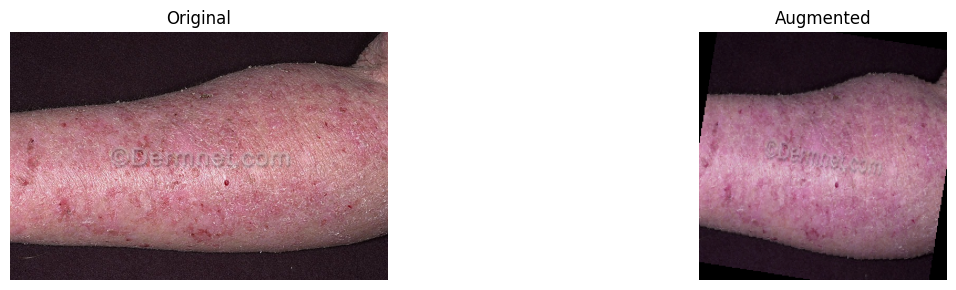

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# Load one image
img = Image.open('/content/drive/MyDrive/data/Eczema/03DermatitisArm.jpg')

# Define the transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Apply and plot
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].imshow(img)
axs[0].set_title("Original")
axs[0].axis("off")

for i in range(1, 2):
    aug_img = transform(img)
    axs[i].imshow(aug_img)
    axs[i].set_title(f"Augmented")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


In [2]:
!pip install pyflowchart

In [11]:
from graphviz import Digraph

dot = Digraph(comment='CNN + BiLSTM Model Architecture')

dot.node('Start', 'Start')
dot.node('C1', 'Conv2d(3 -> 32)\nKernel:3x3, Padding=1')
dot.node('BN1', 'BatchNorm2d(32)')
dot.node('ReLU1', 'ReLU')
dot.node('Pool1', 'MaxPool2d(2x2)')

dot.node('C2', 'Conv2d(32 -> 64)\nKernel:3x3, Padding=1')
dot.node('BN2', 'BatchNorm2d(64)')
dot.node('ReLU2', 'ReLU')
dot.node('Pool2', 'MaxPool2d(2x2)')

dot.node('C3', 'Conv2d(64 -> 128)\nKernel:3x3, Padding=1')
dot.node('BN3', 'BatchNorm2d(128)')
dot.node('ReLU3', 'ReLU')
dot.node('Pool3', 'MaxPool2d(2x2)')

dot.node('Reshape', 'Reshape for LSTM\n(batch, seq_len, 128)')
dot.node('LSTM', 'Bidirectional LSTM\ninput_size=128, hidden_size=64')
dot.node('SelectLast', 'Select last output from LSTM')

dot.node('FC1', 'Fully Connected\n(128 -> 64)')
dot.node('Dropout', 'Dropout(0.5)')
dot.node('ReLU4', 'ReLU')
dot.node('FC2', 'Fully Connected\n(64 -> 1)')
dot.node('Sigmoid', 'Sigmoid Activation')
dot.node('Output', 'Output Prediction')
dot.node('End', 'End')

# Now connect the nodes
# Correct way to add edges: list of (from_node, to_node)
dot.edges([
    ('Start', 'C1'), ('C1', 'BN1'), ('BN1', 'ReLU1'), ('ReLU1', 'Pool1'),
    ('Pool1', 'C2'), ('C2', 'BN2'), ('BN2', 'ReLU2'), ('ReLU2', 'Pool2'),
    ('Pool2', 'C3'), ('C3', 'BN3'), ('BN3', 'ReLU3'), ('ReLU3', 'Pool3')
])

# Add edges one by one or as a list for the rest
dot.edge('Pool3', 'Reshape')
dot.edge('Reshape', 'LSTM')
dot.edge('LSTM', 'SelectLast')
dot.edge('SelectLast', 'FC1')
dot.edge('FC1', 'Dropout')
dot.edge('Dropout', 'ReLU4')
dot.edge('ReLU4', 'FC2')
dot.edge('FC2', 'Sigmoid')
dot.edge('Sigmoid', 'Output')
dot.edge('Output', 'End')


# Render and save
dot.render('cnn_bilstm_model_flowchart', format='png', view=True)


'cnn_bilstm_model_flowchart.png'